# FCNN CWT Classifier for Plant Waves
----

#### PREPROCESSING:

In [1]:
import numpy as np
import torch
import pickle
import os
import pywt
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

%run ../src/utils/constants.py
PLOTS_THESIS = RESULTS_DIR / "plots-thesis"

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [2]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [3]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [4]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [5]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [6]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

Just in case you want to use the 191k dataset, run the following line of code. Don't load the `train_81k_file`.

In [ ]:
train_81k = train_191k
len(train_81k)

Define method for cwt feature extraction for train, test, validation.

In [7]:
def extract_cwt_features(wav_slice):
    # 1. Downsampling
    wav_slice_np = wav_slice.numpy()
    downsample_factor = 50
    downsampled_wav = wav_slice_np[::downsample_factor]

    # Values were determined experimentally.
    freq_range = (1, 6)
    scales = SAMPLING_RATE / (downsample_factor * 2 * np.arange(freq_range[0], freq_range[1]))

    cwt_coeffs, frequencies = pywt.cwt(downsampled_wav, scales, wavelet='morl')

    # Compute abs because it will be used for plot as well and values are more obvious.
    abs_coeffs = np.abs(cwt_coeffs)

    # Normalization (per-sample)
    mean_coeffs = np.mean(abs_coeffs)
    std_dev_coeffs = np.std(abs_coeffs)

    normalized_coeffs = (abs_coeffs - mean_coeffs) / (std_dev_coeffs + 0.00000001)
    
    return normalized_coeffs, scales

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset for train, test, val.

##### Train 81k

Extract spectral features, i.e. the CWT coefficients. Downsample the signal for faster computation.

 20%|███████▎                            | 2483/12130 [00:04<00:14, 671.29it/s]

cwt_coeffs_train_81k.shape (5, 200)
sample_features_train_81k.shape (1000,)


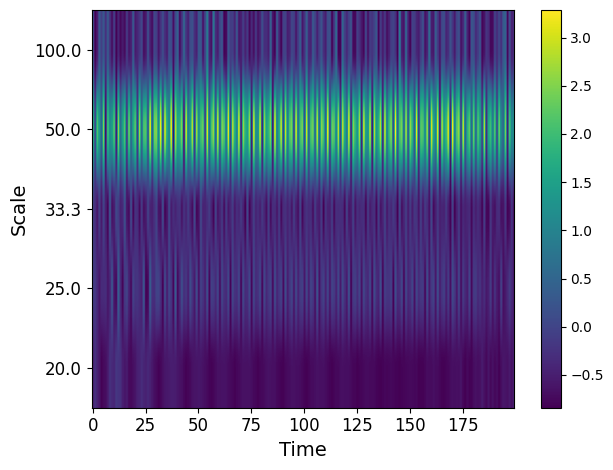

100%|███████████████████████████████████| 12130/12130 [00:19<00:00, 624.66it/s]


In [17]:
wav_slices_train_81k = []
labels_train_81k = []
counter = 0
for segment_train_81k in tqdm(train_81k):  
    cwt_coeffs_train_81k, scales = extract_cwt_features(segment_train_81k[0])
    sample_features_train_81k = cwt_coeffs_train_81k.flatten()
    wav_slices_train_81k.append(sample_features_train_81k)
    
    labels_train_81k.append(segment_train_81k[1])

    if counter == 2500: 
        print("cwt_coeffs_train_81k.shape", cwt_coeffs_train_81k.shape)
        print("sample_features_train_81k.shape", sample_features_train_81k.shape) 

        plt.imshow(cwt_coeffs_train_81k, aspect='auto')
        plt.yticks(np.arange(len(scales)), np.round(scales,decimals=1))
        plt.colorbar()
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Scale', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_THESIS, "scaleogram-cwt.pdf"), format='pdf')
        plt.show()

    counter += 1

Create train dataset 81k. 

In [ ]:
wav_slices_train_81k = torch.tensor(np.array(wav_slices_train_81k), dtype=torch.float32)
labels_train_81k = torch.tensor(np.array(labels_train_81k), dtype=torch.long)
dataset_train_81k = TensorDataset(wav_slices_train_81k, labels_train_81k)

##### Test 81k

In [ ]:
wav_slices_test_81k = []
labels_test_81k = []
for segment_test_81k in tqdm(test_81k):  
    cwt_coeffs_test_81k, _ = extract_cwt_features(segment_test_81k[0])
    sample_features_test_81k = cwt_coeffs_test_81k.flatten()
    wav_slices_test_81k.append(sample_features_test_81k)
    
    labels_test_81k.append(segment_test_81k[1])

Create test dataset 81k. 

In [ ]:
wav_slices_test_81k = torch.tensor(np.array(wav_slices_test_81k), dtype=torch.float32)
labels_test_81k = torch.tensor(np.array(labels_test_81k), dtype=torch.long)
dataset_test_81k = TensorDataset(wav_slices_test_81k, labels_test_81k)

##### Validation 81k

In [ ]:
wav_slices_val_81k = []
labels_val_81k = []
for segment_val_81k in tqdm(val_81k):  
    cwt_coeffs_val_81k, _ = extract_cwt_features(segment_val_81k[0])
    sample_features_val_81k = cwt_coeffs_val_81k.flatten()
    wav_slices_val_81k.append(sample_features_val_81k)
    
    labels_val_81k.append(segment_val_81k[1])

Create validation dataset 81k. 

In [ ]:
wav_slices_val_81k = torch.tensor(np.array(wav_slices_val_81k), dtype=torch.float32)
labels_val_81k = torch.tensor(np.array(labels_val_81k), dtype=torch.long)
dataset_val_81k = TensorDataset(wav_slices_val_81k, labels_val_81k)

#### Create dataloaders

In [ ]:
batch_size = 32

In [ ]:
train81k_loader = DataLoader(dataset_train_81k, batch_size)
test81k_loader = DataLoader(dataset_test_81k, batch_size)
val81k_loader = DataLoader(dataset_val_81k, batch_size)

#### Hyperparameter Optimization

In [ ]:
import wandb
import math
import optuna
from optuna.trial import TrialState
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

Define the FCNN model.

In [ ]:
def define_model(trial):
    layers = []

    INPUT_DIM = 1000 #5000 for ds_factor=10 # 2500 for ds_factor=20 # 1000 for ds_factor=50 # 
    N_CLASSES = 6
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.1, 0.2])

    hidden_dim_1 = trial.suggest_categorical("hidden_dim_1", [2 ** i for i in range(4, 8)])

    layers.append(torch.nn.Linear(INPUT_DIM, hidden_dim_1))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Dropout(dropout_rate))

    hidden_dim_2 = trial.suggest_categorical("hidden_dim_2", [2 ** i for i in range(4, 7)])
    
    layers.append(torch.nn.Linear(hidden_dim_1, hidden_dim_2))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Dropout(dropout_rate))
    
    layers.append(torch.nn.Linear(hidden_dim_2, N_CLASSES))

    config_dict = {
        "hidden_dim_1": hidden_dim_1,
        "hidden_dim_2": hidden_dim_2,
        "dropout_rate": dropout_rate
    }

    return torch.nn.Sequential(*layers), config_dict

Define the objective function for optuna for the hyperparameter optimization.

##### Run without W&B

In [ ]:
def objective_without_wandb(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_hidden1-{config_dict['hidden_dim_1']}_hidden2-"
                       f"{config_dict['hidden_dim_2']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return balanced_accuracy

##### Run with W&B

In [ ]:
def objective(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_hidden1-{config_dict['hidden_dim_1']}_hidden2-"
                       f"{config_dict['hidden_dim_2']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    wandb.init(
        project="model_" + NAME_CORE + "-hpo",
        dir=LOGS_DIR,
        name=name_experiment,
        config=config_dict
    )


    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        f1_class = f1_score(all_labels, all_preds, average=None, zero_division=0.0)
        f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0.0)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        metrics = {
            "balanced_accuracy": balanced_accuracy,
            "accuracy": accuracy,
            "f1_weighted": f1_weighted,
            "recall": recall,
            "precision": precision
        }

        wandb_input = metrics
        wandb.log(wandb_input)

    wandb.finish()

    return balanced_accuracy

##### Run hyperparameter optimization using optuna. Specify a study name and define the search space for the grid search. 

In [ ]:
search_space = {
    'lr': [0.0001, 0.001, 0.01],
    'hidden_dim_1': [2 ** i for i in range(4, 8)],
    'hidden_dim_2': [2 ** i for i in range(4, 7)],
    "dropout_rate": [0, 0.1, 0.2]
}

In [ ]:
num_combi = 1
for i in search_space:
    num_combi *= len(search_space[i])
num_combi

In [ ]:
NAME_CORE = f"fcnn_cwt_6_191k_ds_10_search_{num_combi}"
NUM_EPOCHS = 20
NAME_CORE

In [ ]:
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(sampler=sampler, study_name=NAME_CORE, storage="sqlite:///hpo_" + NAME_CORE + ".db",
                            direction="maximize", load_if_exists=True)

ADJUST `objective` function: with or without W&B!

In [ ]:
study.optimize(objective, n_trials=num_combi)

Closer look into the trials. 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))
print("  Number of pruned trials: ", len(pruned_trials))

print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)
print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

#### ds rate 10 hpo results
Study statistics: 
  Number of finished trials:  108
  Number of complete trials:  17
  Number of pruned trials:  91
Best trial:
  Value:  0.2302674881584178
  Params: 
    dropout_rate: 0.0
    hidden_dim_1: 128
    hidden_dim_2: 32
    lr: 0.001

#### ds rate 20 hpo results
Study statistics: 
  Number of finished trials:  108
  Number of complete trials:  8
  Number of pruned trials:  100
Best trial:
  Value:  0.2329141311064817
  Params: 
    dropout_rate: 0.0
    hidden_dim_1: 128
    hidden_dim_2: 64
    lr: 0.0001

#### Training the Baseline FCNN.
10 times training with the best HP from HPO, and then average. 

#### Testing the Baseline Classifier

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

%run ../src/utils/constants.py

In [ ]:
test_81k_folder = "test-81k"

# DELETE

In [ ]:
import numpy as np

In [ ]:
freq_range = (1, 6)
scales = 10000 / (50 * 2 * np.arange(freq_range[0], freq_range[1]))
scales

In [ ]:
np.arange(freq_range[0], freq_range[1])

In [ ]:
2 * np.arange(freq_range[0], freq_range[1])

In [ ]:
50 * 2 * np.arange(freq_range[0], freq_range[1])